In [113]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import cartopy.crs as ccrs
from PIL import Image
import dask
from datetime import date, timedelta

In [114]:
M = 0.8 #change later
reference_fuel_consumption = 0.7296 #who knows
reference_nox = 19.1835 #IDGAF
number_of_engines = 2 
temp_sea_level = 288.15 #kelvins
pres_sea_level = 101325 #pascals
gamma = 1.4
R = 287.05


In [115]:
#merge echam, accf and contrail datasets for each month into datasets representing whole year
directory = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal")
directory_1percent = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_1pc")
directory_soc = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_optimal")
dir = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal"
dir_1percent = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_1pc"
dir_soc = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_optimal"
echam_files = []
accf_files = []
contrail_files = []
airtraf_files = []
airtraf_ac_co_files = []
airtraf_ac_1percent_files = []
airtraf_ac_soc_files = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("ECHAM5.nc"):
        echam_files.append(os.path.join(dir, filename))
    elif filename.endswith("accf_gp.nc"):
        accf_files.append(os.path.join(dir, filename))
    elif filename.endswith("contrail_gp.nc"):
        contrail_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_gp.nc"):
        airtraf_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_ac.nc"):
        airtraf_ac_co_files.append(os.path.join(dir, filename))
    else:
        continue
for file in os.listdir(directory_1percent):
    filename = os.fsdecode(file)
    if filename.endswith("airtraf_ac.nc"):
        airtraf_ac_1percent_files.append(os.path.join(dir_1percent, filename))
    else:
        continue
for file in os.listdir(directory_soc):
    filename = os.fsdecode(file)
    if filename.endswith("airtraf_ac.nc"):
        airtraf_ac_soc_files.append(os.path.join(dir_soc, filename))
    else:
        continue
if echam_files:
    merged_echam = xr.open_mfdataset(echam_files, combine='nested', concat_dim='time')
if accf_files:
    merged_accf = xr.open_mfdataset(accf_files, combine='nested', concat_dim='time')
if contrail_files:
    merged_contrail = xr.open_mfdataset(contrail_files, combine='nested', concat_dim='time')
if airtraf_files:
    merged_airtraf = xr.open_mfdataset(airtraf_files, combine='nested', concat_dim='time')
if airtraf_ac_co_files:
    merged_airtraf_ac_co = xr.open_mfdataset(airtraf_ac_co_files, combine='nested', concat_dim='time')
if airtraf_ac_1percent_files:
    merged_airtraf_ac_1percent = xr.open_mfdataset(airtraf_ac_1percent_files, combine='nested', concat_dim='time')
if airtraf_ac_soc_files:
    merged_airtraf_ac_soc = xr.open_mfdataset(airtraf_ac_soc_files, combine='nested', concat_dim='time')

In [116]:
#taking 2018 as the only time period
merged_echam = merged_echam.sel(time = slice("2018-01-01", "2018-12-31"))
merged_accf = merged_accf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_contrail = merged_contrail.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf = merged_airtraf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_co = merged_airtraf_ac_co.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_1percent = merged_airtraf_ac_1percent.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_soc = merged_airtraf_ac_soc.sel(time = slice("2018-01-01", "2018-12-31"))
#calculates mean for each month and creates new dataarrays
merged_echam_compressed = []
merged_accf_compressed = []
merged_contrail_compressed = []
merged_airtraf_compressed = []
for i in range(1,13):
    merged_echam_compressed.append(merged_echam.sel(time=merged_echam['time.month'] == i).mean(dim='time'))
    merged_accf_compressed.append(merged_accf.sel(time=merged_accf['time.month'] == i).mean(dim='time'))
    merged_contrail_compressed.append(merged_contrail.sel(time=merged_contrail['time.month'] == i).mean(dim='time'))
    merged_airtraf_compressed.append(merged_airtraf.sel(time=merged_airtraf['time.month'] == i).mean(dim='time'))
merged_echam_compressed = xr.concat(merged_echam_compressed, dim='time')
merged_accf_compressed = xr.concat(merged_accf_compressed, dim='time')
merged_contrail_compressed = xr.concat(merged_contrail_compressed, dim='time')
merged_airtraf_compressed = xr.concat(merged_airtraf_compressed, dim='time')
#months go from '1-12', the index starts at '0' as for all arrays

In [117]:
#aircrafts velocity based on its mach number
velocity = M*np.sqrt(gamma*R*merged_echam_compressed['tm1']) #m/s
#correction coefficients for fuel consumption
delta = merged_echam_compressed['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta = merged_echam_compressed['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i = reference_fuel_consumption*delta*np.sqrt(theta) #kg/s
#total fuel consumption
f_cr = f_a_i*number_of_engines #kg/s
#humidity correction coefficient
H_c = np.exp(-19*(merged_echam_compressed['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x = reference_nox*delta**0.4*theta**0.3*H_c #g/kg
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm = merged_accf_compressed['atr20_co2']/velocity*f_cr*1000 #K/km
h2o_atr20_perkm = merged_accf_compressed['atr20_h2o']/velocity*f_cr*1000 #K/km
o3_atr20_perkm = merged_accf_compressed['atr20_o3']/velocity*f_cr*EINO_x*10**(-3)*1000 #K/km
ch4_atr20_perkm = merged_accf_compressed['atr20_ch4']/velocity*f_cr*EINO_x*10**(-3)*1000 #K/km
contr_atr20_perkm = merged_accf_compressed['atr20_contrail']*merged_contrail_compressed['potcov'] #?
total_atr20_perkm = co2_atr20_perkm + h2o_atr20_perkm + o3_atr20_perkm + ch4_atr20_perkm + contr_atr20_perkm


In [118]:
#aircrafts velocity based on its mach number
velocity_uncompressed = M*np.sqrt(gamma*R*merged_echam['tm1']) #m/s
#correction coefficients for fuel consumption
delta_uncompressed = merged_echam['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta_uncompressed = merged_echam['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i_uncompressed = reference_fuel_consumption*delta_uncompressed*np.sqrt(theta_uncompressed) #kg/s
#total fuel consumption
f_cr_uncompressed = f_a_i_uncompressed*number_of_engines #kg/s
#humidity correction coefficient
H_c_uncompressed = np.exp(-19*(merged_echam['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x_uncompressed = reference_nox*delta_uncompressed**0.4*theta_uncompressed**0.3*H_c_uncompressed #g/kg
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm_uncompressed = merged_accf['atr20_co2']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
h2o_atr20_perkm_uncompressed = merged_accf['atr20_h2o']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
o3_atr20_perkm_uncompressed = merged_accf['atr20_o3']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
ch4_atr20_perkm_uncompressed = merged_accf['atr20_ch4']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
contr_atr20_perkm_uncompressed = merged_accf['atr20_contrail']*merged_contrail['potcov'] #?
total_atr20_perkm_uncompressed = co2_atr20_perkm_uncompressed + h2o_atr20_perkm_uncompressed + o3_atr20_perkm_uncompressed + ch4_atr20_perkm_uncompressed + contr_atr20_perkm_uncompressed


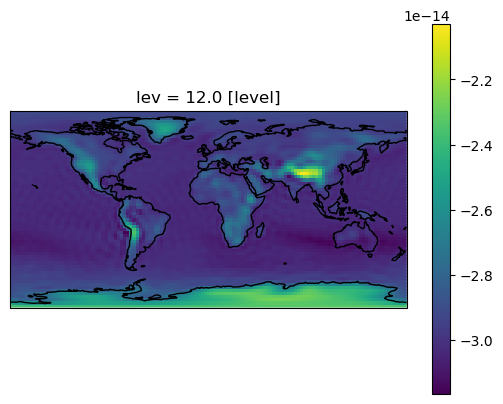

In [104]:
var = ch4_atr20_perkm.isel(time=7).sel(lev=12.0)
#var = var.where(var > 1e-20)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

#extent = [-25, 60, 20, 70]
#ax.set_extent(extent)
p = var.plot(transform=ccrs.PlateCarree())#,vmin=6.9e-15, vmax=7.2e-15)

2018-01-01
Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40


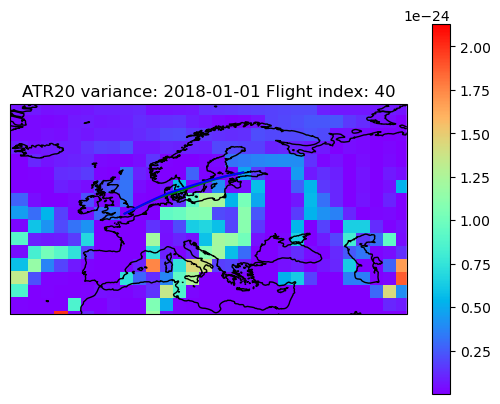

In [143]:
#calculates the mean, standard deviation and later on variance. Right now the main issue is with selecting the corresponding portion
#of the globe and adjusting the heatmap to not lose informations
time = total_atr20_perkm_uncompressed.coords['time'].values
levels = np.arange(7,15)
total_atr20_perkm_uncompressed_mean = total_atr20_perkm_uncompressed.sel(lev=slice(7,14)).mean(dim=['time','lev'], keep_attrs=True).expand_dims({'time':time})
total_atr20_perkm_uncompressed_sd = total_atr20_perkm_uncompressed.sel(lev=slice(7,14)).std(dim=['time','lev'], keep_attrs=True).expand_dims({'time':time})
total_atr20_perkm_uncompressed_mean = total_atr20_perkm_uncompressed_mean.expand_dims({'lev':levels})
total_atr20_perkm_uncompressed_sd = total_atr20_perkm_uncompressed_sd.expand_dims({'lev':levels})
total_atr20_perkm_uncompressed_difference = (total_atr20_perkm_uncompressed.sel(lev=slice(7,14)) - total_atr20_perkm_uncompressed_mean)
total_atr20_perkm_uncompressed_divided = total_atr20_perkm_uncompressed_difference / total_atr20_perkm_uncompressed_sd
total_atr20_perkm_uncompressed_variance = total_atr20_perkm_uncompressed_divided.var(dim='lev')
total_atr20_perkm_uncompressed_variance_mean_month = []
for i in range(1,13):
    total_atr20_perkm_uncompressed_variance_mean_month.append(total_atr20_perkm_uncompressed_variance.sel(time=total_atr20_perkm_uncompressed_variance['time.month'] == i).mean(dim='time'))
total_atr20_perkm_uncompressed_variance_mean_month = xr.concat(total_atr20_perkm_uncompressed_variance_mean_month, dim='time')


start_date = date(2018, 1, 1)
end_date = date(2018, 1, 2)
time_delta = timedelta(days=1)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

for current_date in daterange(start_date, end_date):
    var = total_atr20_perkm_uncompressed.sel(lev=slice(7,14)).var(dim='lev')
    var = xr.concat([var.sel(lon=slice(0,67.5)), var.sel(lon=slice(337.5, 357.1875))], dim="lon")
    current_date = str(current_date)
    print(current_date)
    var = var.sel(time=current_date).sel(lat=slice(87.8638,18.138971))
    for i in range(41):
        print("Index: " + str(i))
        plt.clf()
        #var = total_atr20_perkm_uncompressed_variance_mean_month.sel(time=0)
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        extent = [-25, 60, 30, 70]
        ax.set_extent(extent)

        # for i in range(1):
        #     lon = merged_airtraf_ac_co.variables['routes_out'].isel(time=0, AirTraf_routes_out=i, AirTraf_properties=0).data
        #     lat = merged_airtraf_ac_co.variables['routes_out'].isel(time=0, AirTraf_routes_out=i, AirTraf_properties=1).data
            
        #     plt.plot(lon, lat, transform=ccrs.PlateCarree())

        #     lon = merged_airtraf_ac_1percent.variables['routes_out'].isel(time=0, AirTraf_routes_out=i, AirTraf_properties=0).data
        #     lat = merged_airtraf_ac_1percent.variables['routes_out'].isel(time=0, AirTraf_routes_out=i, AirTraf_properties=1).data

        #     plt.plot(lon, lat, transform=ccrs.PlateCarree())


        lon = merged_airtraf_ac_co['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
        lat = merged_airtraf_ac_co['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

        plt.plot(lon, lat, transform=ccrs.PlateCarree(), color='green')

        lon = merged_airtraf_ac_soc['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
        lat = merged_airtraf_ac_soc['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

        plt.plot(lon, lat, transform=ccrs.PlateCarree(), color = 'blue')

        p = var.plot(transform=ccrs.PlateCarree(), cmap = 'rainbow')#,vmin=6.9e-15, vmax=7.2e-15)
        plt.title(label='ATR20 variance: ' + current_date + ' Flight index: ' + str(i) )
        plt.savefig('C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/Midnight_img/' + current_date + '-' + str(i))



2018-01-01
Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40


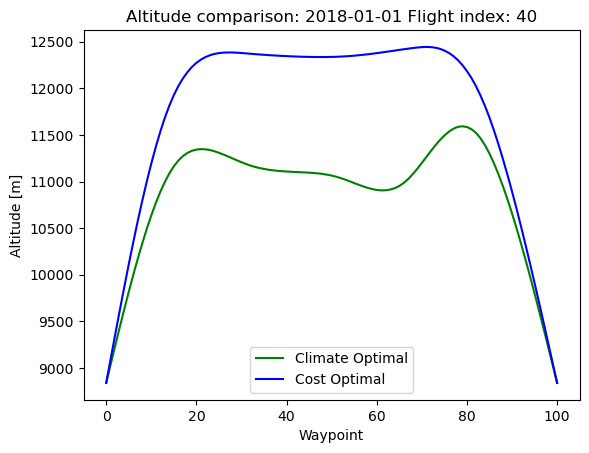

In [144]:
for current_date in daterange(start_date, end_date):
    current_date = str(current_date)
    print(current_date)
    for i in range(41):
        print("Index: " + str(i))
        plt.clf()
        plt.title(label='')
        alt_co = merged_airtraf_ac_co['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=2).data
        alt_soc = merged_airtraf_ac_soc['routes_out'].sel(time=current_date).isel(AirTraf_routes_out=i, AirTraf_properties=2).data
        plt.plot(alt_co, color='g')
        plt.plot(alt_soc, color='b')
        ax = plt.gca()
        ax.legend(['Climate Optimal', 'Cost Optimal'])
        plt.xlabel('Waypoint')
        plt.ylabel('Altitude [m]')
        plt.title(label='Altitude comparison: ' + current_date + ' Flight index: ' + str(i) )
        plt.savefig("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/Midnight_img/" + current_date + '-' + str(i) + '-alt')



In [146]:
directory_midnight_img = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/Midnight_img")
dir_midnight_img = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/Midnight_img"
for current_date in daterange(start_date, end_date):
    current_date = str(current_date)
    print(current_date)
    for i in range(41):
        print("Index: " + str(i))
        img_list = []
        
        for file in os.listdir(directory_midnight_img):
            filename = os.fsdecode(file)
            if filename.endswith(current_date + '-' + str(i) + '.png'):
                img_list.append(os.path.join(dir_midnight_img, filename))
            elif filename.endswith(current_date + '-' + str(i) + '-alt' + '.png'):
                img_list.append(os.path.join(dir_midnight_img, filename))
            else:
                continue
            
        images = [Image.open(x) for x in img_list]
        widths, heights = zip(*(p.size for p in images))

        total_width = sum(widths)
        max_height = max(heights)

        new_im = Image.new('RGB', (total_width, max_height))

        x_offset = 0
        for im in images:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]

        new_im.save("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/combined_img/" + current_date + '-' + str(i) + '.png')

2018-01-01
Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
